[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/jtooates/blind_lm/blob/main/experiments/toy_class_latents.ipynb)

# Toy Experiment: Class Label Latents

**Goal**: Test whether loss functions can prevent speckles while encoding information.

**Setup**:
- 100 learnable latents (one per class) - configurable for grayscale or RGB
- Tiny MLP decoder: latent → class prediction
- Same losses as real training (InfoNCE, batch InfoNCE, magnitude, Mumford-Shah)

**Question**: Can we encode 100 classes smoothly, or do speckles emerge?

**Configuration**: Change `latent_c` in cell 4:
- `latent_c = 1` for grayscale (32×32×1)
- `latent_c = 3` for RGB (32×32×3)

In [1]:
# Colab setup: Clone or update repository
import os

if 'google.colab' in str(get_ipython()):
    print("Running on Google Colab")
    
    repo_dir = '/content/blind_lm'
    repo_url = 'https://github.com/jtooates/blind_lm.git'
    
    if os.path.exists(repo_dir):
        print("Repository exists. Pulling latest changes...")
        %cd {repo_dir}
        !git pull origin main
        print("✓ Repository updated")
    else:
        print("Cloning repository...")
        %cd /content
        !git clone {repo_url}
        print("✓ Repository cloned")
    
    # Navigate to experiments directory
    %cd {repo_dir}/experiments
    print(f"Current directory: {os.getcwd()}")
else:
    print("Running locally")
    # Assume we're already in the right directory

Running locally


In [2]:
import sys
import os

# Add phase1 to path
if 'google.colab' in str(get_ipython()):
    # On Colab, we're in /content/blind_lm/experiments
    sys.path.insert(0, '/content/blind_lm/phase1')
else:
    # Running locally
    sys.path.insert(0, '../phase1')

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import AdamW
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

# Import loss functions from phase1
from infonce_losses import InfoNCEPatchLoss, InfoNCEPatchLossL2, MagnitudeLoss
from batch_infonce_loss import BatchInfoNCELoss

# Mumford-Shah loss for bounded homogeneous regions
class MumfordShahLoss(nn.Module):
    """
    Mumford-Shah loss for piecewise constant regions.
    
    Encourages the latent to be smooth within regions but allows
    sharp boundaries between regions.
    
    Uses ISOTROPIC gradient norm (rotation-invariant) so boundaries
    can form at any angle, not just horizontal/vertical.
    
    The key insight: L2 smoothness term heavily penalizes gradients
    (wants constant regions), but L1 boundary term allows sparse
    boundaries to exist (linear cost doesn't explode for edges).
    """
    def __init__(self, alpha=1.0, beta=0.1, epsilon=1e-6):
        super().__init__()
        self.alpha = alpha  # Smoothness within regions (L2)
        self.beta = beta    # Boundary sparsity (L1)
        self.epsilon = epsilon  # Numerical stability
    
    def forward(self, latent):
        """
        Args:
            latent: [B, H, W, C] RGB latent
        Returns:
            Scalar loss
        """
        # Compute gradients in horizontal and vertical directions
        diff_h = latent[:, 1:, :, :] - latent[:, :-1, :, :]  # [B, H-1, W, C]
        diff_w = latent[:, :, 1:, :] - latent[:, :, :-1, :]  # [B, H, W-1, C]
        
        # Crop to same size for isotropic gradient magnitude
        diff_h_crop = diff_h[:, :, :-1, :]  # [B, H-1, W-1, C]
        diff_w_crop = diff_w[:, :-1, :, :]  # [B, H-1, W-1, C]
        
        # Isotropic gradient magnitude at each pixel (rotation invariant!)
        # This makes diagonal boundaries cost the same as horizontal/vertical
        grad_magnitude = (diff_h_crop.pow(2) + diff_w_crop.pow(2) + self.epsilon).sqrt()
        
        # Smoothness term: L2 penalty on gradient magnitude
        # Heavily penalizes gradients - wants regions to be constant
        smoothness = grad_magnitude.pow(2).mean()
        
        # Boundary term: L1 penalty on gradient magnitude
        # Allows sparse boundaries to exist at any angle
        boundary = grad_magnitude.mean()
        
        return self.alpha * smoothness + self.beta * boundary

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Device: {device}')

Device: cpu


## 1. Setup: Learnable Latents and Decoder

In [ ]:
# Configuration
num_classes = 100
latent_h = 32
latent_w = 32
latent_c = 1  # 1 for grayscale, 3 for RGB
use_grayscale = (latent_c == 1)

# Learnable latents (one per class)
# Initialize with small random values
latents = nn.Parameter(torch.randn(num_classes, latent_h, latent_w, latent_c) * 0.1)
print(f'Latents shape: {latents.shape}')
print(f'Latents parameters: {latents.numel():,}')
print(f'Mode: {"Grayscale" if use_grayscale else "RGB"}')

In [ ]:
# Tiny MLP Decoder
class TinyClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim=256, num_classes=100):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, num_classes)
    
    def forward(self, latents_bhwc):
        """
        Args:
            latents_bhwc: [B, H, W, C] latent images
        Returns:
            logits: [B, num_classes]
        """
        B = latents_bhwc.shape[0]
        x = latents_bhwc.reshape(B, -1)  # Flatten
        x = F.relu(self.fc1(x))
        logits = self.fc2(x)
        return logits

# Create decoder with correct input dimension
input_dim = latent_h * latent_w * latent_c
decoder = TinyClassifier(input_dim=input_dim).to(device)
print(f'\nDecoder input dim: {input_dim}')
print(f'Decoder parameters: {sum(p.numel() for p in decoder.parameters()):,}')

## 2. Loss Functions

In [5]:
# Loss function configuration
config = {
    'use_l2_infonce': False,     # NEW: Set to True to use L2 distance instead of cosine similarity
    
    'lambda_class': 1.0,        # Classification (must encode class ID)
    'lambda_infonce': 0.0,      # Spatial smoothness within latent
    'lambda_batch_infonce': 0.0,  # Different classes look different
    'lambda_magnitude': 1.0,    # Prevent collapse
    'lambda_mumford_shah': 4.0, # NEW: Piecewise constant regions with boundaries
    
    # InfoNCE parameters
    'patch_size': 5,
    'num_samples': 25,
    'temperature': 1.0,
    'positive_radius': 7.0,
    'negative_radius': 14.0,
    
    # Batch InfoNCE parameters
    'batch_infonce_temperature': 1.0,
    'batch_infonce_cross_image_radius': 5.0,
    'batch_infonce_num_cross_images': 8,
    
    # Magnitude
    'min_magnitude': 0.3,
    
    # Mumford-Shah parameters
    'mumford_shah_alpha': 5.0,  # NEW: Within-region smoothness (L2)
    'mumford_shah_beta': 25.0,    # NEW: Boundary sparsity (L1)
}

# Initialize loss functions
class_loss_fn = nn.CrossEntropyLoss()

# Choose InfoNCE variant
if config['use_l2_infonce']:
    print('Using InfoNCE with L2 distance (constrains magnitude + direction)')
    infonce_loss_fn = InfoNCEPatchLossL2(
        patch_size=config['patch_size'],
        num_samples=config['num_samples'],
        temperature=config['temperature'],
        positive_radius=config['positive_radius'],
        negative_radius=config['negative_radius']
    ).to(device)
else:
    print('Using InfoNCE with cosine similarity (direction only)')
    infonce_loss_fn = InfoNCEPatchLoss(
        patch_size=config['patch_size'],
        num_samples=config['num_samples'],
        temperature=config['temperature'],
        positive_radius=config['positive_radius'],
        negative_radius=config['negative_radius']
    ).to(device)

batch_infonce_loss_fn = BatchInfoNCELoss(
    patch_size=config['patch_size'],
    num_samples=config['num_samples'],
    temperature=config['batch_infonce_temperature'],
    cross_image_radius=config['batch_infonce_cross_image_radius'],
    num_cross_images=config['batch_infonce_num_cross_images']
).to(device)

magnitude_loss_fn = MagnitudeLoss(
    min_magnitude=config['min_magnitude']
).to(device)

mumford_shah_loss_fn = MumfordShahLoss(
    alpha=config['mumford_shah_alpha'],
    beta=config['mumford_shah_beta']
).to(device)

print('Loss functions initialized')
print(f"  lambda_class: {config['lambda_class']}")
print(f"  lambda_infonce: {config['lambda_infonce']}")
print(f"  lambda_batch_infonce: {config['lambda_batch_infonce']}")
print(f"  lambda_magnitude: {config['lambda_magnitude']}")
print(f"  lambda_mumford_shah: {config['lambda_mumford_shah']}")

Using InfoNCE with cosine similarity (direction only)
Loss functions initialized
  lambda_class: 1.0
  lambda_infonce: 0.0
  lambda_batch_infonce: 0.0
  lambda_magnitude: 1.0
  lambda_mumford_shah: 4.0


## 3. Training Loop

In [6]:
# Optimizer
optimizer = AdamW([
    {'params': [latents], 'lr': 1e-2},
    {'params': decoder.parameters(), 'lr': 1e-3}
])

# Training settings
num_steps = 2000
batch_size = 32
log_interval = 10

# Track losses
history = {
    'total': [],
    'class': [],
    'infonce': [],
    'batch_infonce': [],
    'magnitude': [],
    'mumford_shah': [],
    'accuracy': []
}

print(f'Training for {num_steps} steps with batch size {batch_size}...')
print()

Training for 2000 steps with batch size 32...



In [7]:
# Training loop
latents_param = latents.to(device)

pbar = tqdm(range(num_steps), ncols = 150)
for step in pbar:
    optimizer.zero_grad()
    
    # Sample random batch of class IDs
    class_ids = torch.randint(0, num_classes, (batch_size,), device=device)
    
    # Look up corresponding latents
    batch_latents = latents_param[class_ids]  # [batch_size, H, W, C]
    
    # Decode to class predictions
    logits = decoder(batch_latents)
    
    # 1. Classification loss
    if config['lambda_class'] == 0:
        loss_class = torch.tensor(0.0, device=device)
    else:
        loss_class = class_loss_fn(logits, class_ids)
    
    # 2. InfoNCE loss (spatial smoothness within each latent)
    if config['lambda_infonce'] == 0:
        loss_infonce = torch.tensor(0.0, device=device)
    else:
        loss_infonce = infonce_loss_fn(batch_latents)
    
    # 3. Batch InfoNCE loss (different classes look different)
    if config['lambda_batch_infonce'] == 0:
        loss_batch_infonce = torch.tensor(0.0, device=device)
    else:
        if batch_size > 1:
            loss_batch_infonce = batch_infonce_loss_fn(batch_latents)
        else:
            loss_batch_infonce = torch.tensor(0.0, device=device)
    
    # 4. Magnitude loss
    if config['lambda_magnitude'] == 0:
        loss_magnitude = torch.tensor(0.0, device=device)
    else:
        loss_magnitude = magnitude_loss_fn(batch_latents)
    
    # 5. Mumford-Shah loss (piecewise constant regions)
    if config['lambda_mumford_shah'] == 0:
        loss_mumford_shah = torch.tensor(0.0, device=device)
    else:
        loss_mumford_shah = mumford_shah_loss_fn(batch_latents)
    
    # Total loss
    total_loss = (
        config['lambda_class'] * loss_class +
        config['lambda_infonce'] * loss_infonce +
        config['lambda_batch_infonce'] * loss_batch_infonce +
        config['lambda_magnitude'] * loss_magnitude +
        config['lambda_mumford_shah'] * loss_mumford_shah
    )
    
    # Backward
    total_loss.backward()
    optimizer.step()
    
    # Track metrics
    with torch.no_grad():
        accuracy = (logits.argmax(dim=1) == class_ids).float().mean()
    
    history['total'].append(total_loss.item())
    history['class'].append(loss_class.item())
    history['infonce'].append(loss_infonce.item())
    history['batch_infonce'].append(loss_batch_infonce.item())
    history['magnitude'].append(loss_magnitude.item())
    history['mumford_shah'].append(loss_mumford_shah.item())
    history['accuracy'].append(accuracy.item())
    
    # Update progress bar
    if step % log_interval == 0:
        pbar.set_postfix({
            'loss': f"{total_loss.item():.2f}",
            'acc': f"{accuracy.item():.2f}",
            'cls': f"{loss_class.item():.2f}",
            'inf': f"{loss_infonce.item():.2f}",
            'bat': f"{loss_batch_infonce.item():.2f}",
            'mag': f"{loss_magnitude.item():.2f}",
            'ms': f"{loss_mumford_shah.item():.2f}"
        })

print('\nTraining complete!')

100%|███████████████████████████████████████| 2000/2000 [00:32<00:00, 61.99it/s, loss=1.75, acc=1.00, cls=0.00, inf=0.00, bat=0.00, mag=0.25, ms=0.37]


Training complete!


## 4. Visualization: Loss Curves

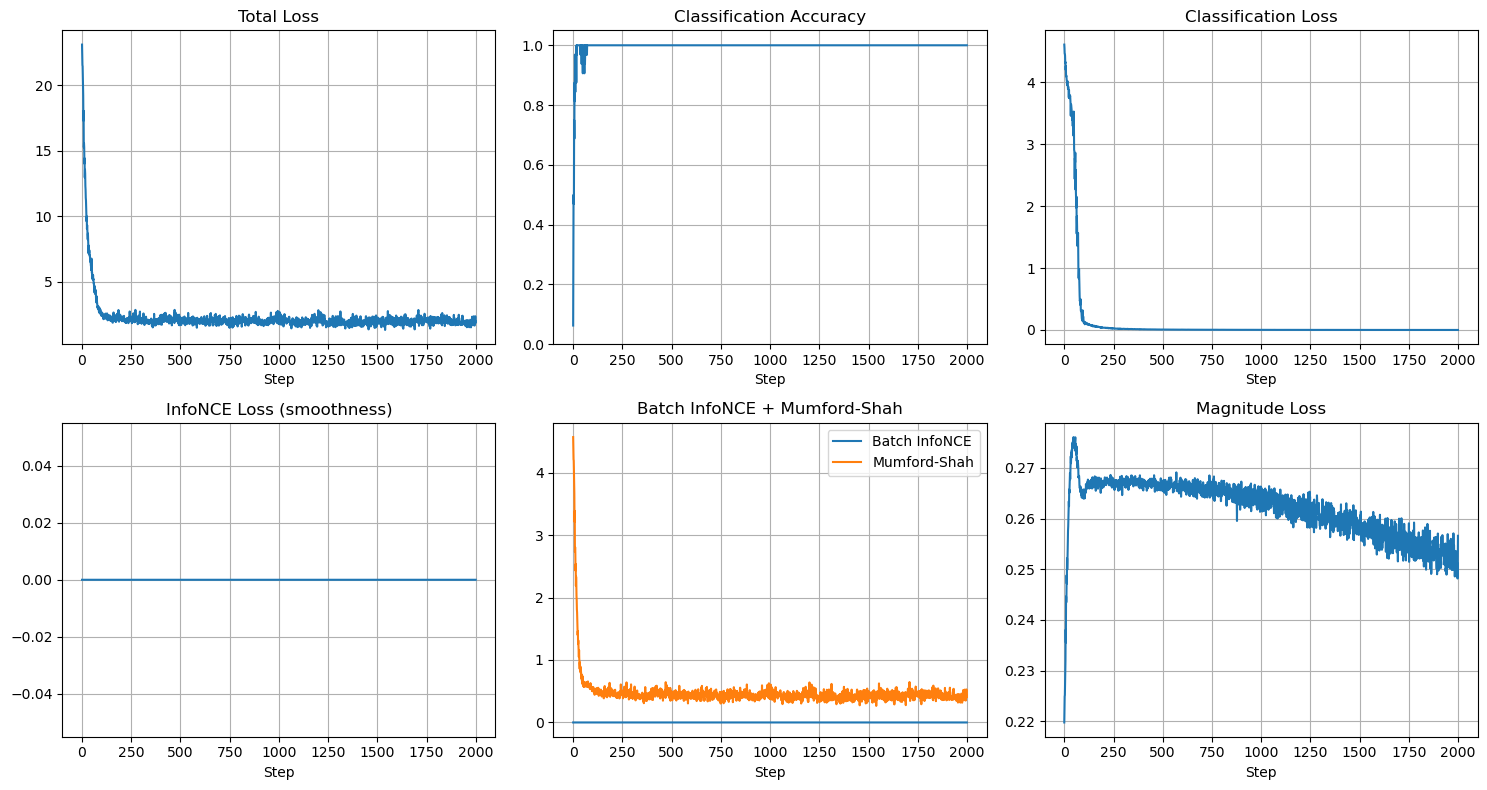

Final accuracy: 1.000


In [8]:
fig, axes = plt.subplots(2, 3, figsize=(15, 8))

axes[0, 0].plot(history['total'])
axes[0, 0].set_title('Total Loss')
axes[0, 0].set_xlabel('Step')
axes[0, 0].grid(True)

axes[0, 1].plot(history['accuracy'])
axes[0, 1].set_title('Classification Accuracy')
axes[0, 1].set_xlabel('Step')
axes[0, 1].set_ylim([0, 1.05])
axes[0, 1].grid(True)

axes[0, 2].plot(history['class'])
axes[0, 2].set_title('Classification Loss')
axes[0, 2].set_xlabel('Step')
axes[0, 2].grid(True)

axes[1, 0].plot(history['infonce'])
axes[1, 0].set_title('InfoNCE Loss (smoothness)')
axes[1, 0].set_xlabel('Step')
axes[1, 0].grid(True)

axes[1, 1].plot(history['batch_infonce'], label='Batch InfoNCE')
axes[1, 1].plot(history['mumford_shah'], label='Mumford-Shah')
axes[1, 1].set_title('Batch InfoNCE + Mumford-Shah')
axes[1, 1].set_xlabel('Step')
axes[1, 1].legend()
axes[1, 1].grid(True)

axes[1, 2].plot(history['magnitude'])
axes[1, 2].set_title('Magnitude Loss')
axes[1, 2].set_xlabel('Step')
axes[1, 2].grid(True)

plt.tight_layout()
plt.show()

print(f'Final accuracy: {history["accuracy"][-1]:.3f}')

## 5. Visualization: Learned Latents

Show all 100 learned latent images. Look for speckles!

In [ ]:
def latent_to_display(latent_tensor):
    """Convert [H, W, C] tensor to displayable format, normalized to [0, 1]"""
    img = latent_tensor.detach().cpu().numpy()
    
    # Normalize to [0, 1] for display
    img = (img - img.min()) / (img.max() - img.min() + 1e-8)
    img = np.clip(img, 0, 1)
    
    # If grayscale (C=1), squeeze the channel dimension for display
    if img.shape[-1] == 1:
        img = img.squeeze(-1)
    
    return img

# Show grid of all latents
num_rows = 10
num_cols = 10

fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 20))

for i in range(num_classes):
    row = i // num_cols
    col = i % num_cols
    
    display_img = latent_to_display(latents_param[i])
    
    # Display with appropriate colormap
    if use_grayscale:
        axes[row, col].imshow(display_img, cmap='gray', vmin=0, vmax=1)
    else:
        axes[row, col].imshow(display_img)
    
    axes[row, col].set_title(f'{i}', fontsize=8)
    axes[row, col].axis('off')

mode_str = 'Grayscale' if use_grayscale else 'RGB'
plt.suptitle(f'Learned Latents for {num_classes} Classes ({mode_str})', fontsize=16)
plt.tight_layout()
plt.show()

print('\nExamine the images above:')
print('  - Are they smooth or speckled?')
print('  - Do different classes look different?')
print('  - Is there visible structure?')

## 6. Analysis: Speckle Detection

Quantify high-frequency content (speckles) in the latents

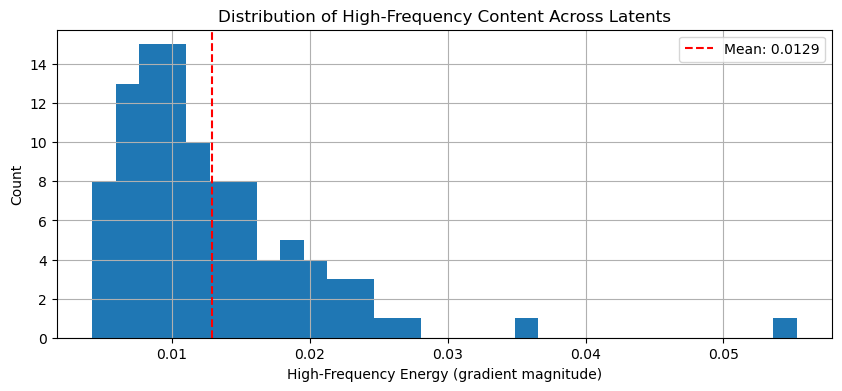

Average high-frequency energy: 0.0129
Std dev: 0.0072

Higher values = more speckles/high-frequency content


In [10]:
def compute_high_freq_energy(latent):
    """Measure high-frequency energy using gradient magnitude"""
    # Compute gradients (high freq = large gradients)
    grad_y = latent[1:, :, :] - latent[:-1, :, :]
    grad_x = latent[:, 1:, :] - latent[:, :-1, :]
    
    # Average gradient magnitude
    return (grad_y.abs().mean() + grad_x.abs().mean()) / 2

# Compute for all latents
with torch.no_grad():
    high_freq_energies = []
    for i in range(num_classes):
        energy = compute_high_freq_energy(latents_param[i])
        high_freq_energies.append(energy.item())

plt.figure(figsize=(10, 4))
plt.hist(high_freq_energies, bins=30)
plt.xlabel('High-Frequency Energy (gradient magnitude)')
plt.ylabel('Count')
plt.title('Distribution of High-Frequency Content Across Latents')
plt.axvline(np.mean(high_freq_energies), color='r', linestyle='--', label=f'Mean: {np.mean(high_freq_energies):.4f}')
plt.legend()
plt.grid(True)
plt.show()

print(f'Average high-frequency energy: {np.mean(high_freq_energies):.4f}')
print(f'Std dev: {np.std(high_freq_energies):.4f}')
print(f'\nHigher values = more speckles/high-frequency content')

## 7. Experiment: Test Different Loss Configurations

Compare results with different settings to see what prevents speckles

In [11]:
# Save current results
baseline_latents = latents_param.detach().clone()
baseline_energy = np.mean(high_freq_energies)
baseline_accuracy = history['accuracy'][-1]

print('Baseline (current) results saved:')
print(f'  High-freq energy: {baseline_energy:.4f}')
print(f'  Final accuracy: {baseline_accuracy:.3f}')
print(f'  Config: lambda_infonce={config["lambda_infonce"]}, positive_radius={config["positive_radius"]}')

Baseline (current) results saved:
  High-freq energy: 0.0129
  Final accuracy: 1.000
  Config: lambda_infonce=0.0, positive_radius=7.0


### Experiment: Higher InfoNCE Weight

Test if increasing lambda_infonce reduces speckles

In [12]:
# You can copy the training loop above and modify config['lambda_infonce']
# Then compare the resulting latents visually and quantitatively

print('To experiment:')
print('1. Modify config["lambda_infonce"] (try 5.0, 10.0)')
print('2. Re-run training loop')
print('3. Compare learned latents')
print('4. Compare high-frequency energy')

To experiment:
1. Modify config["lambda_infonce"] (try 5.0, 10.0)
2. Re-run training loop
3. Compare learned latents
4. Compare high-frequency energy


## 8. Experiment: L2 Distance vs Cosine Similarity

**Hypothesis**: L2 distance constrains both direction AND magnitude, preventing checkerboard speckles.

**To test**:
1. Set `config['use_l2_infonce'] = True` in cell 6
2. Re-run cells 6-15
3. Compare learned latents and high-frequency energy

**Expected result**: L2 variant should produce smoother latents with less checkerboard texture.

In [13]:
print('L2-based InfoNCE variant is now available!')
print()
print('To compare:')
print('  1. Cosine (current): use_l2_infonce=False')
print('  2. L2 distance: use_l2_infonce=True')
print()
print('Expected difference:')
print('  - Cosine: May produce checkerboards (magnitude variations allowed)')
print('  - L2: Should be smoother (magnitude constrained)')

L2-based InfoNCE variant is now available!

To compare:
  1. Cosine (current): use_l2_infonce=False
  2. L2 distance: use_l2_infonce=True

Expected difference:
  - Cosine: May produce checkerboards (magnitude variations allowed)
  - L2: Should be smoother (magnitude constrained)


## 9. Experiment: Mumford-Shah Loss for Bounded Regions

**What it does**: Creates piecewise constant regions with sharp boundaries (object-like shapes).

**How it works**:
- **L2 smoothness term** (alpha): Heavily penalizes gradients → wants constant regions
- **L1 boundary term** (beta): Lightly penalizes gradients → allows sparse boundaries
- **Isotropic gradient norm**: Uses rotation-invariant gradient magnitude so boundaries can form at ANY angle (not just horizontal/vertical)

**Control parameters**:
1. `lambda_mumford_shah`: Overall weight of the loss (0 = disabled, higher = stronger effect)
2. `mumford_shah_alpha`: Within-region smoothness (L2 term, default 10.0)
3. `mumford_shah_beta`: Boundary sparsity (L1 term, default 0.5)

**To enable**:
1. Set `config['lambda_mumford_shah'] = 2.0` (or higher) in cell 7
2. Adjust `alpha` and `beta` if needed
3. Re-run training (cells 7-15)

**Parameter tuning**:
- **lambda_mumford_shah**: Controls overall influence (start with 1.0-5.0)
- **alpha too high** → everything becomes one color (increase beta or decrease alpha)
- **alpha too low** → speckles remain (increase alpha)
- **beta too low** → over-segmented into tiny regions (increase beta)
- **beta too high** → can't form distinct regions (decrease beta)
- Good starting ratio: `alpha/beta ≈ 5-20`

**Expected results**:
- Large smooth color regions within each latent
- Sharp boundaries between regions at arbitrary angles (not just H/V)
- Fewer high-frequency speckles
- Geometric structure emerges (blob/shape patterns)